# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [77]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

from mapseq.core import *
from mapseq.barcode import *
from mapseq.utils import *
from mapseq.bowtie import *

gitpath=os.path.expanduser("~/git/mapseq-analysis")
sys.path.append(gitpath)

from msanalysis.analysis import * 

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the file containing the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. We also have a convenience method to package up the FASTQ file pairs.  

In [74]:
#cp = get_default_config()
configfile = os.path.expanduser('~/project/mapseq/M205.htna24/M205.mapseq.conf')
cp = ConfigParser()
cp.read(configfile)
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M205.htna24/M205_sampleinfo.xlsx')
expid = 'M205.htna24'
bcfile = os.path.expanduser( cp.get('barcodes','ssifile') )
 
infilelist = [
    os.path.expanduser('~/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz')
          ]
infiles = package_pairfiles(infilelist)
outdir = os.path.expanduser('~/project/mapseq/M205.htna24')
print(f"For {expid}:\nconfig={configfile}\nbcfile={bcfile}\ninfiles={infiles}\noutdir={outdir}")

INFO:root:input pair of readfiles: r1=/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz r2=/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz


For M205.htna24:
config=/Users/hover/project/mapseq/M205.htna24/M205.mapseq.conf
bcfile=/Users/hover/git/mapseq-processing/etc/barcode_v2.txt
infiles=[('/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz', '/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz')]
outdir=/Users/hover/project/mapseq/M205.htna24


In [57]:
sampdf = load_sample_info(cp, sampleinfo)
sampdf

,usertube,samplename,ourtube,siteinfo,rtprimer,brain,region
0,OB,Olfactory Bulb,1.0,target-negative,1,YW143,OB
1,ACB,ACB,2.0,target,2,YW143,ACB
2,AI,AI,3.0,target,3,YW143,AI
3,CP,CP (dorsal part - can just dissect out the top...,4.0,target,4,YW143,CP
4,MTN,MTN,5.0,target,5,YW143,MTN
5,BLAa,BLAa,6.0,target,6,YW143,BLAa
6,PIR,Piriform Cortex,7.0,target,7,YW143,PIR
7,VTA,VTA,8.0,target,8,YW143,VTA
8,TeA,TeA,9.0,target,9,YW143,TeA
9,ENTl,ENTl,10.0,target,10,YW143,ENTl


In [58]:
# handle all the input. usually takes ~ minutes
# M205.htna24 
rdf = process_fastq_pairs_pd(infiles, outdir=outdir, cp=cp)
os.listdir(outdir)

INFO:root:handling /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz, /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz ...
INFO:root:handling FASTQ /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz
INFO:root:sequence 0
INFO:root:sequence 10000000
INFO:root:done. 17029001 sequences extracted.
INFO:root:handling FASTQ /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz
INFO:root:sequence 0
INFO:root:sequence 10000000
INFO:root:done. 17029001 sequences extracted.
INFO:root:df done. len=17029001 returning...


['read_collapsed.tsv',
 'edgelist.txt',
 'component_count.tsv',
 'vbc_read.unique.tsv',
 'seqmapdict.json',
 'multi_components.json',
 'inj-counts.pdf',
 'vbc_read.unique.fasta',
 'collapse.out',
 'M205_sampleinfo.xlsx',
 'stats.202410101658.json',
 'read1read2.tsv',
 'readtable.out',
 'unique_sequences.btdf.tsv',
 'stats.202410101637.json',
 'unique_sequences.bt2.sam',
 'vbc_read.fulldf.tsv',
 'fastq.out',
 'components.txt',
 'fastq',
 'M194_sampleinfo.xlsx',
 'stats.202410101650.json',
 'stats.202410101631.json',
 'target-counts.pdf',
 'indexes']

In [59]:
rdf.dtypes

sequence    string[pyarrow]
vbc_read    string[pyarrow]
spikeseq    string[pyarrow]
libtag      string[pyarrow]
umi         string[pyarrow]
ssi         string[pyarrow]
dtype: object

In [60]:
rdf

,sequence,vbc_read,spikeseq,libtag,umi,ssi
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCTGGATGGTCACTTG...,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT
1,CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTACC...,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG
2,TACGTAGTAATGGTGTTTACGTCAAACACCCCTGGCGTGGGGGATC...,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGTCC...,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGTCGAGCTTAGGGCC...,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA
...,...,...,...,...,...,...
17028996,GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGGCC...,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG
17028997,CGGTCAGGCATCCACGGCGCTTTAAAATAGTTTTGGCTTCCTTGCT...,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG
17028998,TGACTCATATCTAAACCAGTCCTTGACGAACGCGCAACCTGTGACG...,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT
17028999,GCGCCCCTCATGGCTTGACGGAGATCTCACTCAGTAGTCAGCTACC...,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT


In [61]:
fdf = filter_reads_pd(rdf.copy(), column='sequence' )

INFO:root:remove=True, new len=16931326


In [62]:
fdf

,sequence,vbc_read,spikeseq,libtag,umi,ssi
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCTGGATGGTCACTTG...,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT
1,CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTACC...,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG
2,TACGTAGTAATGGTGTTTACGTCAAACACCCCTGGCGTGGGGGATC...,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGTCC...,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGTCGAGCTTAGGGCC...,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA
...,...,...,...,...,...,...
16931321,GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGGCC...,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG
16931322,CGGTCAGGCATCCACGGCGCTTTAAAATAGTTTTGGCTTCCTTGCT...,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG
16931323,TGACTCATATCTAAACCAGTCCTTGACGAACGCGCAACCTGTGACG...,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT
16931324,GCGCCCCTCATGGCTTGACGGAGATCTCACTCAGTAGTCAGCTACC...,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT


In [63]:
frdf = set_counts_df(fdf.copy(), column='sequence')
frdf.drop('sequence', axis=1, inplace=True)    

In [64]:
frdf

,vbc_read,spikeseq,libtag,umi,ssi,read_count
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT,2
1,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG,2
2,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT,3
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG,2
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA,2
...,...,...,...,...,...,...
16931321,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG,1
16931322,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG,1
16931323,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT,1
16931324,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT,3


In [65]:
cdf = align_collapse_pd(frdf.copy(), 
                       outdir=outdir, 
                       cp=cp)

INFO:root:Getting unique DF...
INFO:root:Writing unique DF to /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.tsv
INFO:root:Writing uniques as FASTA to /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.fasta
INFO:root:Writing slimmed full DF to /Users/hover/project/mapseq/M205.htna24/vbc_read.fulldf.tsv
INFO:root:Running bowtie2 on /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.fasta file to /Users/hover/project/mapseq/M205.htna24/unique_sequences.bt2.sam
INFO:root:Bowtie done. Produced output /Users/hover/project/mapseq/M205.htna24/unique_sequences.bt2.sam. Creating btdf dataframe...
INFO:root:Processed 1000000 entries... 
INFO:root:Calculating Hamming components...
INFO:root:Collapsing 75828 components...
INFO:root:building seqmapdict 715272 unique seqs, 72330 components, for 16931326 raw sequences. 
INFO:root:seqmapdict built. Applying.
INFO:root:applying seqmapdict...
/Users/hover/git/mapseq-processing/mapseq/core.py:1929: FutureWarning: A value is trying to 

In [66]:
cdf

,spikeseq,libtag,umi,ssi,read_count,vbc_read_col
0,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT,2,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG
1,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG,2,CCCAGCTTCTTTATAAGAATAAACGTATTT
2,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT,3,TACGTAGTAATGGTGTTTACGTCAAACACC
3,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG,2,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC
4,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA,2,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT
...,...,...,...,...,...,...
16931321,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG,1,GTGGTGAGCATACGTTGGGGGCCGAGCGGG
16931322,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG,1,CTATTTTAAAGCGCCGTGGATGCCTGACCG
16931323,GACGAACG,CG,CGCAACCTGTGA,CGACAACT,1,TTCGTCAAGGACTGGTTTAGATATGAGTCA
16931324,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT,3,GCGCCCCTCATGGCTTGACGGAGATCTCAC


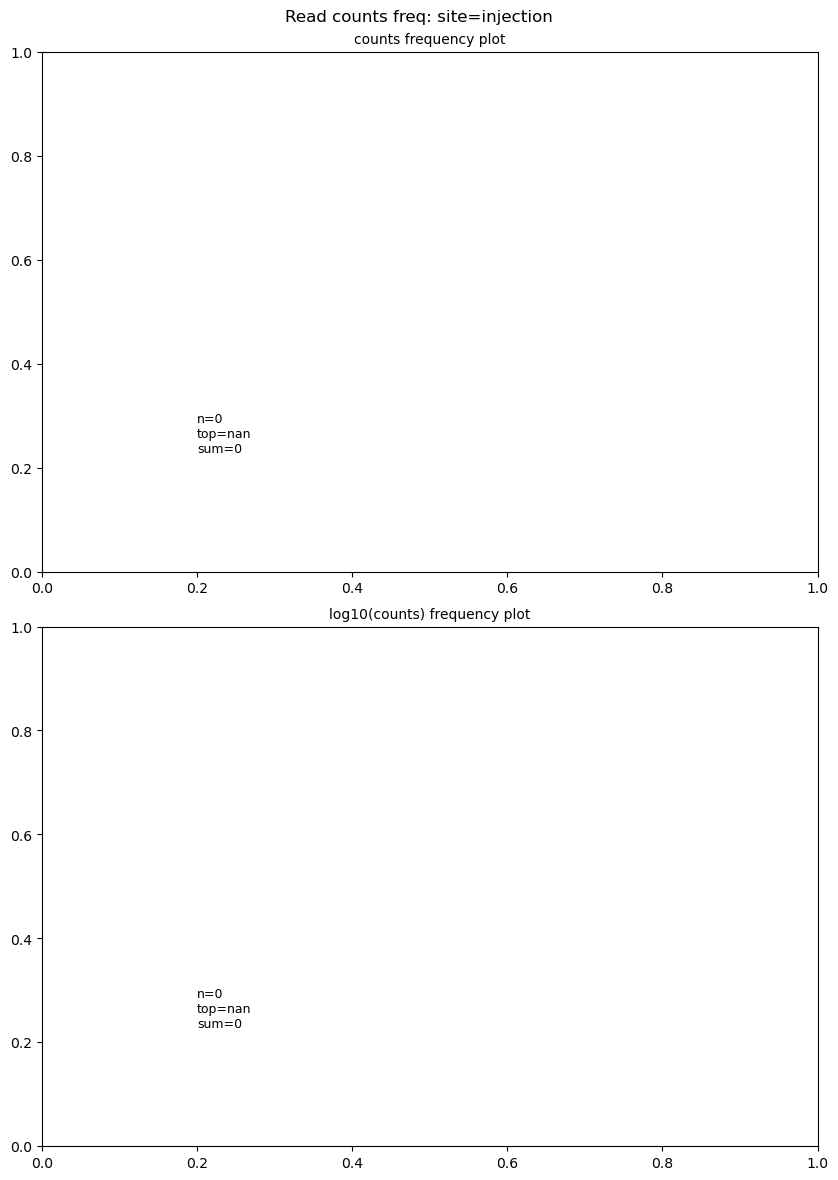

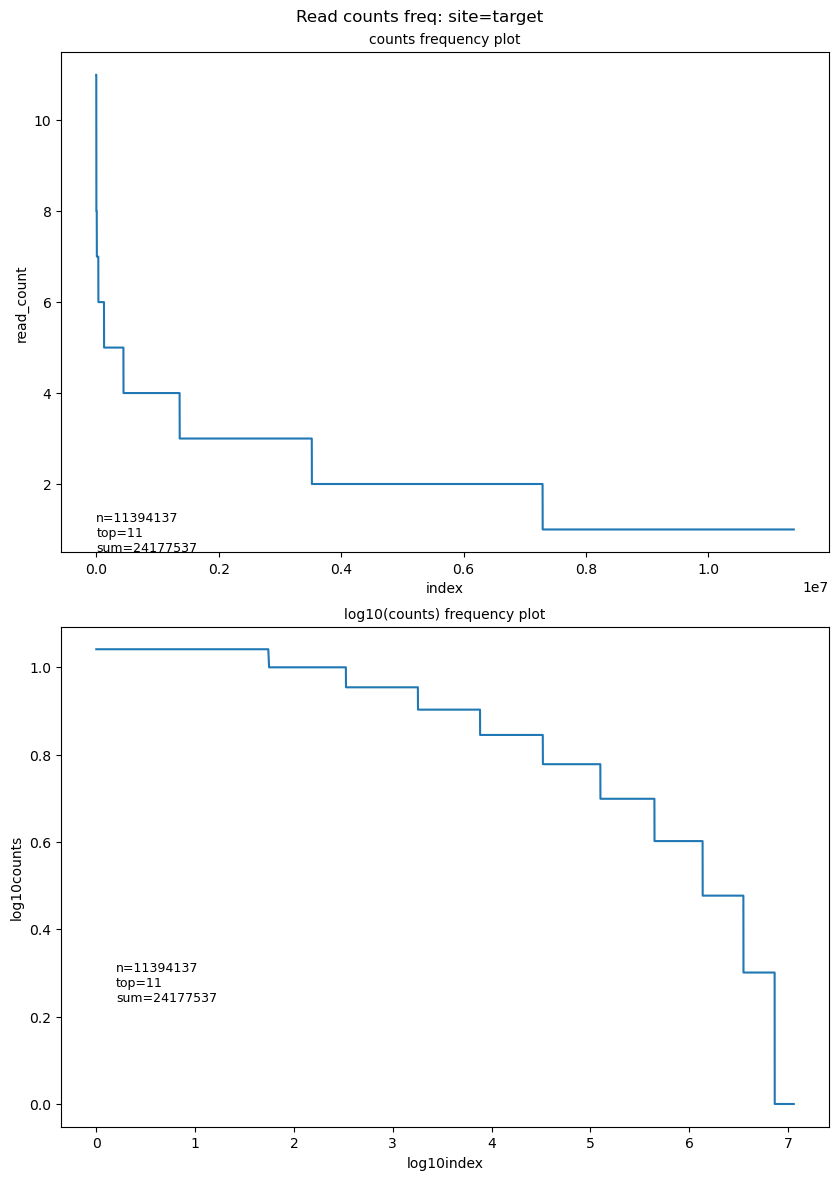

In [67]:
rtdf = process_make_readtable_pd(cdf.copy(),
                                   sampdf,
                                   bcfile=bcfile, 
                                   outdir=outdir, 
                                   cp=cp)

In [68]:
rtdf

,libtag,umi,ssi,read_count,vbc_read_col,label,rtprimer,type,brain,region,site
0,TC,TGGATGGTCACT,TGACACAT,2,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,BC17,17,real,YW144,MTN,target
1,TC,TTTTGGAAGTTA,CCTGGTTG,2,CCCAGCTTCTTTATAAGAATAAACGTATTT,BC16,16,real,YW144,CP,target
2,CC,TGGCGTGGGGGA,TCCTGCCT,3,TACGTAGTAATGGTGTTTACGTCAAACACC,BC14,14,real,YW144,ACB,target
3,TT,CGGGGGTGCCGT,CCTGGTTG,2,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,BC16,16,real,YW144,CP,target
4,GG,TCGAGCTTAGGG,CCGGGGCA,2,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,BC25,25,lone,,L1 ctrl,target-control
...,...,...,...,...,...,...,...,...,...,...,...
16931321,TT,GACACGAACTGG,CCTGGTTG,1,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,BC16,16,real,YW144,CP,target
16931322,TT,TTGGCTTCCTTG,CTGGTCAG,1,CTATTTTAAAGCGCCGTGGATGCCTGACCG,nomatch,nomatch,real,,,
16931323,CG,CGCAACCTGTGA,CGACAACT,1,TTCGTCAAGGACTGGTTTAGATATGAGTCA,nomatch,nomatch,nomatch,,,
16931324,TC,AGTAGTCAGCTA,CCTGGTTT,3,GCGCCCCTCATGGCTTGACGGAGATCTCAC,nomatch,nomatch,real,,,


In [69]:
vdf = process_make_vbctable_pd(rtdf.copy(),
                               outdir=outdir,
                               cp=cp)

INFO:root:dropping redundant readtable columns: libtag ssi rtprimer vbc_read  


In [70]:
vdf

,vbc_read_col,label,type,umi_count,read_count,brain,region,site
0,AAAAAAATATATTTCGACCGCTGCGGGTTT,BC16,real,1,4,YW144,CP,target
1,AAAAAAATCCATTCAGCGGGCGGGATTTCT,BC16,real,14,111,YW144,CP,target
2,AAAAAAATCCGCATTCTATGCGCACTTTCC,BC16,real,1,9,YW144,CP,target
3,AAAAAAATTTCAGCCCTATGGAGCTCCCAG,BC2,real,2,13,YW143,ACB,target
4,AAAAAAATTTCAGCCCTATGGAGCTCCCAG,BC6,real,2,8,YW143,BLAa,target
...,...,...,...,...,...,...,...,...
350315,TTTTTTTGTGTTCACTGATAGGTATTGATC,BC25,lone,1,4,,L1 ctrl,target-control
350316,TTTTTTTGTTAGACGCACATGGTCTAGAGT,BC17,real,2,8,YW144,MTN,target
350317,TTTTTTTGTTCACACGTACAACCCGCATAG,BC4,real,1,9,YW143,CP,target
350318,TTTTTTTGTTCACACGTACAACCCGCATAG,BC6,real,1,4,YW143,BLAa,target


In [75]:
process_make_matrices_pd(vdf.copy(),
                          exp_id = expid,  
                          outdir=outdir, 
                          cp=cp)

/Users/hover/miniconda3/envs/mapseq2/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
INFO:root:done with brain=YW143
/Users/hover/miniconda3/envs/mapseq2/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
INFO:root:done with brain=YW144


In [81]:
flist = os.listdir(outdir)
flist.sort()
flist

['M205.mapseq.conf',
 'M205_sampleinfo.xlsx',
 'YW143.fbcmdf.tsv',
 'YW143.nbcm.tsv',
 'YW143.rbcm.tsv',
 'YW143.sbcm.tsv',
 'YW143.scbcm.tsv',
 'YW144.fbcmdf.tsv',
 'YW144.nbcm.tsv',
 'YW144.rbcm.tsv',
 'YW144.sbcm.tsv',
 'YW144.scbcm.tsv',
 'collapse.out',
 'component_count.tsv',
 'components.txt',
 'edgelist.txt',
 'fastq',
 'fastq.out',
 'indexes',
 'inj-counts.pdf',
 'multi_components.json',
 'read1read2.tsv',
 'read_collapsed.tsv',
 'readtable.out',
 'seqmapdict.json',
 'stats.202410101631.json',
 'stats.202410101637.json',
 'stats.202410101650.json',
 'stats.202410101658.json',
 'stats.202410101749.json',
 'stats.202410101751.json',
 'target-counts.pdf',
 'unique_sequences.bt2.sam',
 'unique_sequences.btdf.tsv',
 'vbc_read.fulldf.tsv',
 'vbc_read.unique.fasta',
 'vbc_read.unique.tsv']

INFO:root:plotting file: YW143.nbcm.tsv
INFO:root:wrote plot(s) to /Users/hover/project/mapseq/M205.htna24/M205.htna24.binarized.pdf


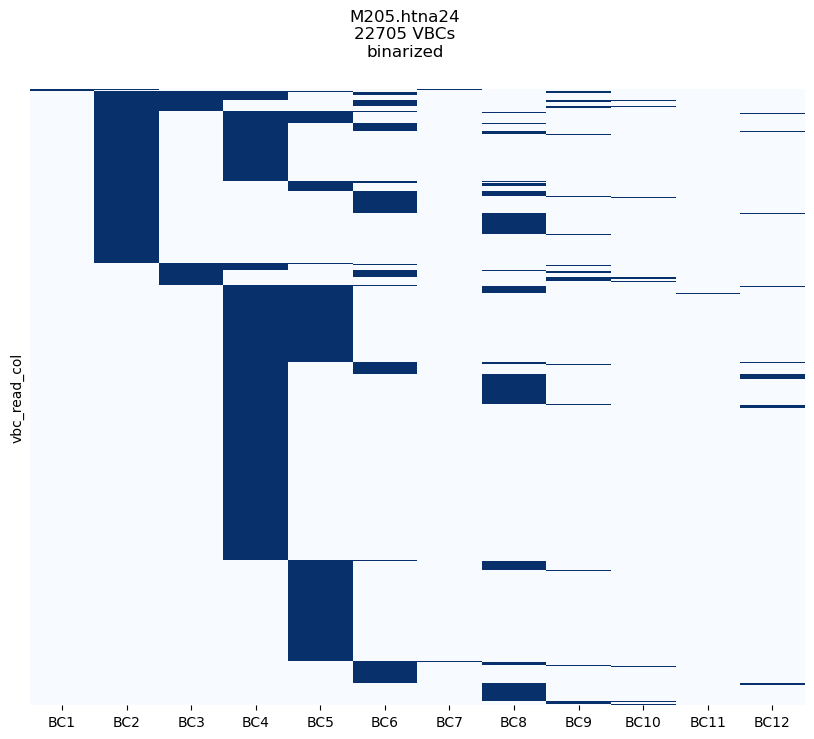

In [84]:
infile = f'{outdir}/YW143.nbcm.tsv'
make_plot_binarized(cp, infile, label=expid) 

INFO:root:plotting file: YW144.nbcm.tsv
INFO:root:wrote plot(s) to /Users/hover/project/mapseq/M205.htna24/M205.htna24.binarized.pdf


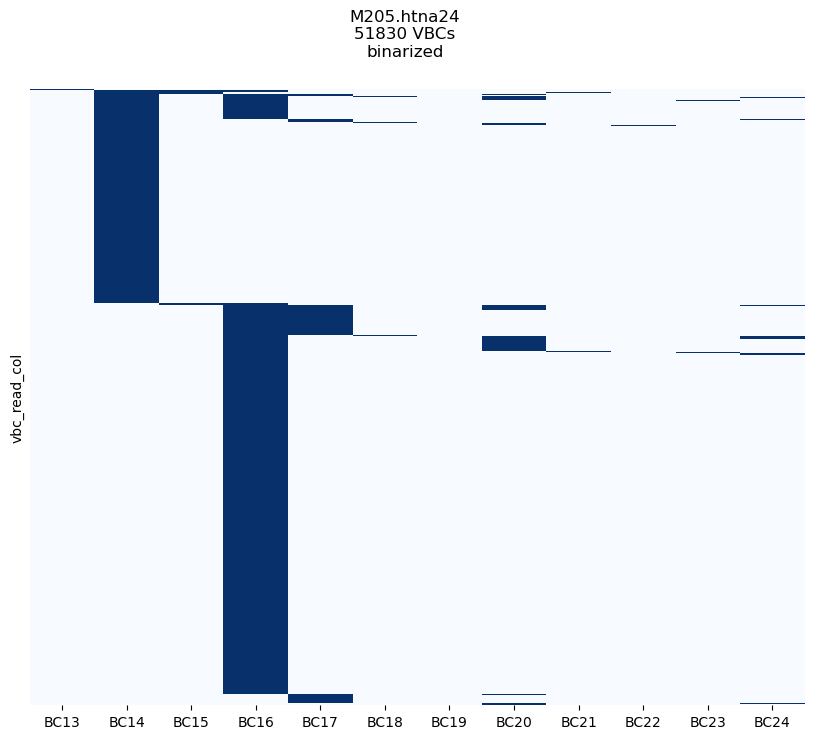

In [85]:
infile = f'{outdir}/YW144.nbcm.tsv'
make_plot_binarized(cp, infile, label=expid) 